<a href="https://colab.research.google.com/github/gabrielpetersson/simple-variational-auto-encoder/blob/master/variational_auto_encoder_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np


Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:00<00:00, 12.7MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 347kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.19MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.80MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



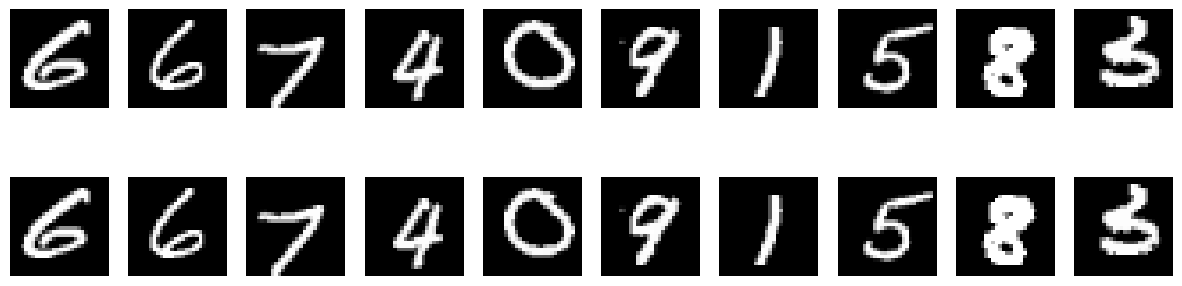

torch.Size([1, 28, 28])


In [2]:
def show_images(images, outputs, n=10):
    images = images[:n]
    outputs = outputs[:n]
    images = images.cpu().numpy()
    outputs = outputs.cpu().detach().numpy()

    # Denormalize images
    images = images * 0.5 + 0.5
    outputs = outputs * 0.5 + 0.5

    fig, axes = plt.subplots(nrows=2, ncols=n, sharex=True, sharey=True, figsize=(15,4))

    for images_row, row in zip([images, outputs], axes):
        for img, ax in zip(images_row, row):
            img = np.squeeze(img)
            ax.imshow(img, cmap='gray')
            ax.axis('off')
    plt.show()


transform = transforms.Compose([
    transforms.RandomCrop(28, padding=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

for images, labels in train_loader:
  show_images(images, images)
  print(images[0].shape)
  break

In [5]:
import torch
import torch.nn as nn

bottleneck = 16  # Dimensionality of the latent space

class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Flatten()
        )

        # Separate layers for mean and log-variance
        self.fc_mu = nn.Linear(128 * 4 * 4, bottleneck)
        self.fc_logvar = nn.Linear(128 * 4 * 4, bottleneck)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck, 128 * 4 * 4),
            nn.BatchNorm1d(128 * 4 * 4),
            nn.LeakyReLU(0.2),

            nn.Unflatten(1, (128, 4, 4)),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),

            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)  # Calculate the standard deviation
        eps = torch.randn_like(std)    # Sample epsilon from a standard normal distribution
        return mu + eps * std          # Reparameterization trick

    def forward(self, x):
        encoded = self.encoder(x)
        mu = self.fc_mu(encoded)       # Mean of the latent space
        logvar = self.fc_logvar(encoded)  # Log-variance of the latent space
        z = self.reparameterize(mu, logvar)  # Sample from the latent space
        decoded = self.decoder(z)      # Decode the sampled latent vector
        return decoded, encoded, mu, logvar

# Example Loss Function for VAE
def vae_loss_function(recon_x, x, mu, logvar):
    # Reconstruction loss (binary cross-entropy or MSE depending on the use case)
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')

    # KL divergence (encourages distribution to be close to standard normal)
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Total loss
    return recon_loss + kl_div


Initial validation loss: 134260.91986875


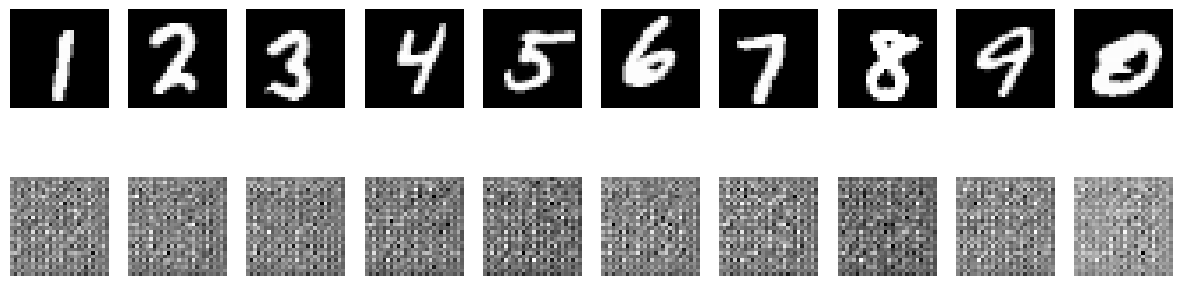

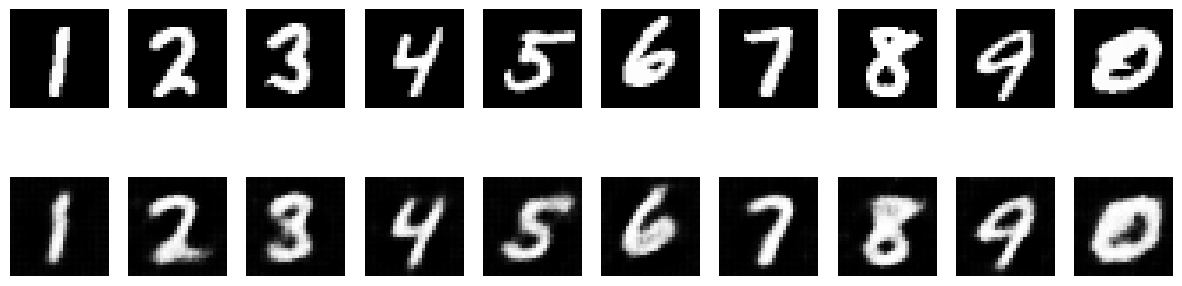

Epoch [1/10], Training Loss: 22369.5985, Validation Loss: 11672.8268


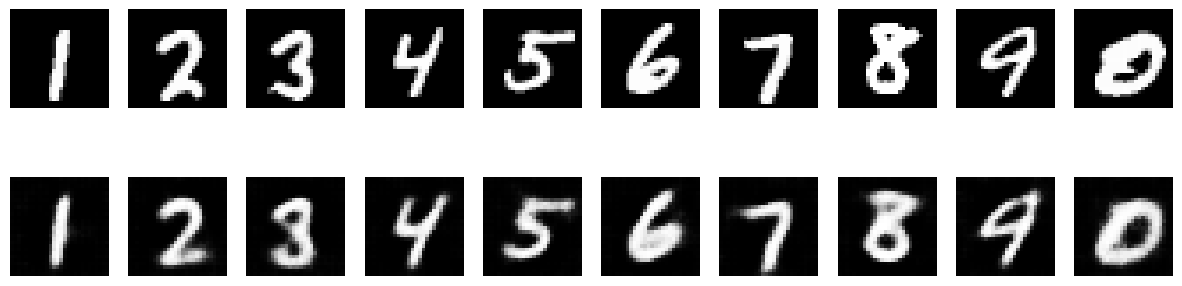

Epoch [2/10], Training Loss: 11067.9268, Validation Loss: 10446.9814


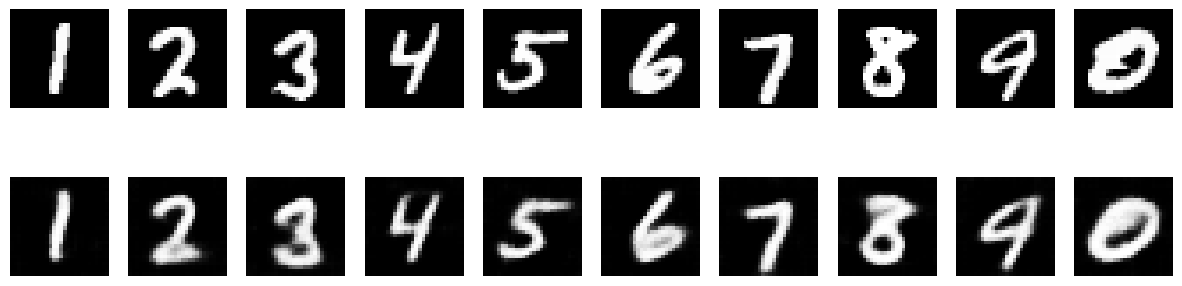

Epoch [3/10], Training Loss: 10323.3845, Validation Loss: 9746.1141


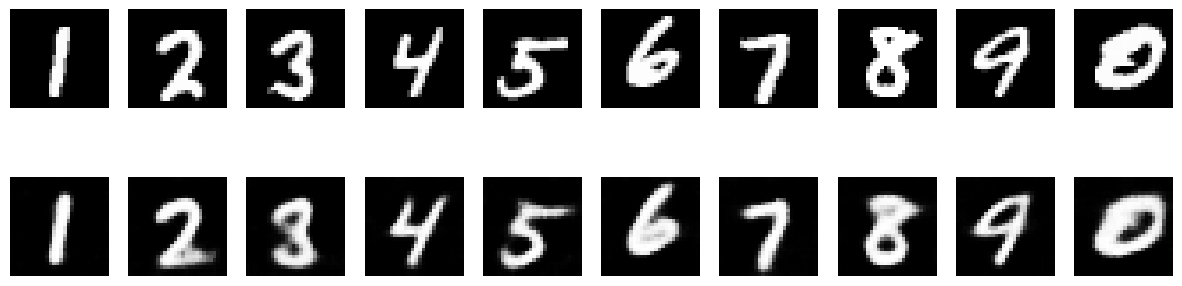

Epoch [4/10], Training Loss: 9903.7757, Validation Loss: 9617.4685


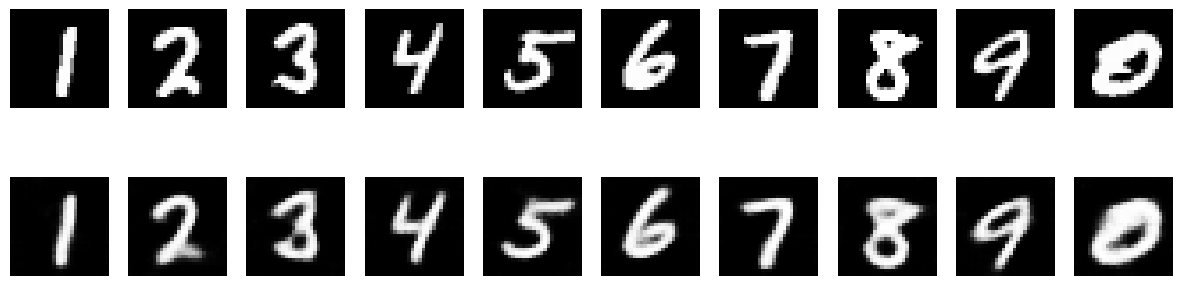

Epoch [5/10], Training Loss: 9671.2664, Validation Loss: 9180.5832


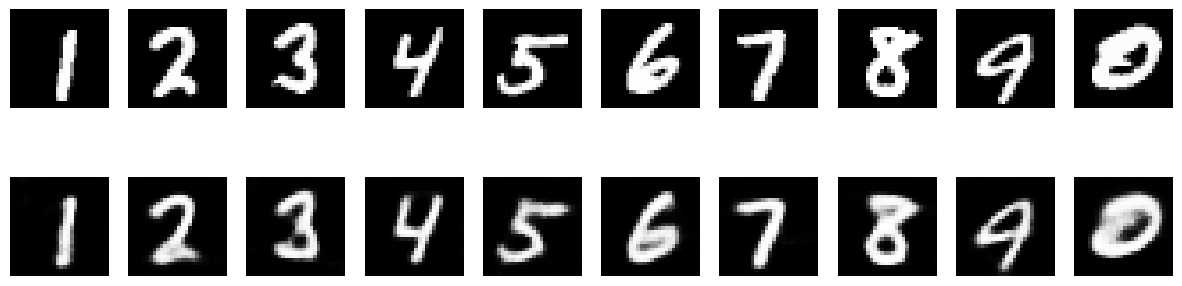

Epoch [6/10], Training Loss: 9464.4189, Validation Loss: 9430.1916


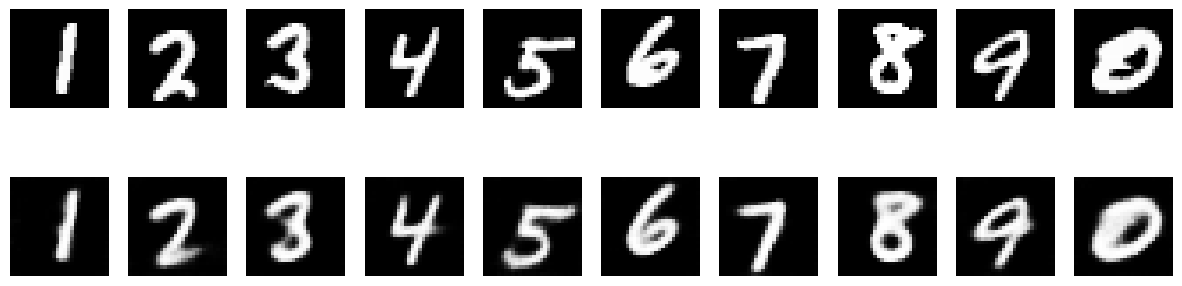

Epoch [7/10], Training Loss: 9345.2158, Validation Loss: 8961.0728


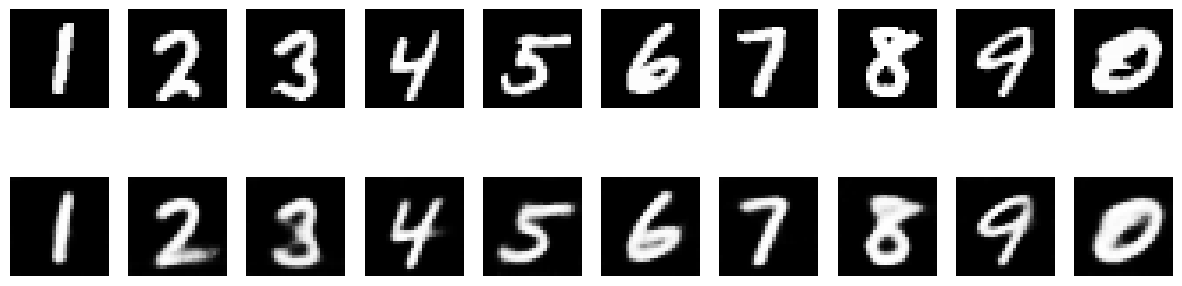

Epoch [8/10], Training Loss: 9269.9579, Validation Loss: 8886.9800


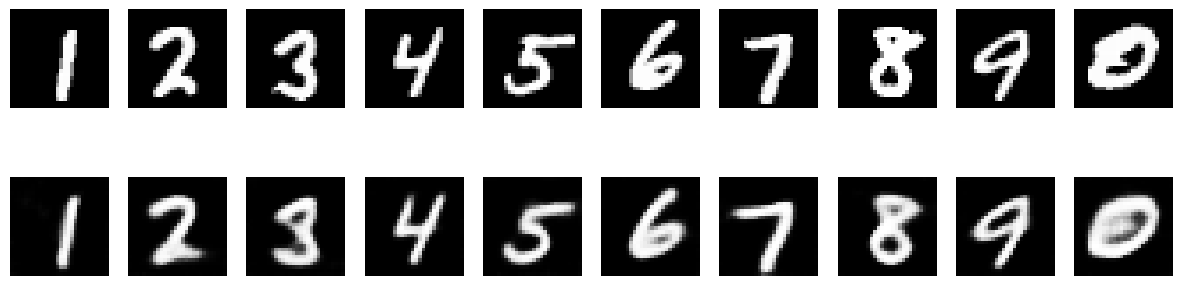

Epoch [9/10], Training Loss: 9158.2529, Validation Loss: 8906.0190


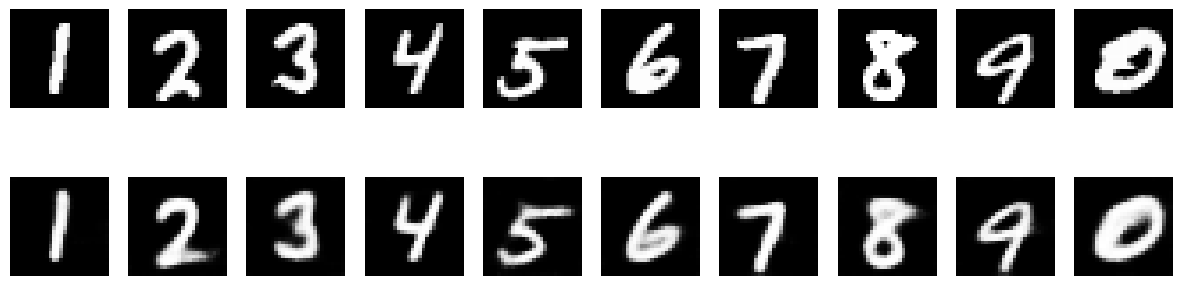

Epoch [10/10], Training Loss: 9073.1697, Validation Loss: 8810.5676


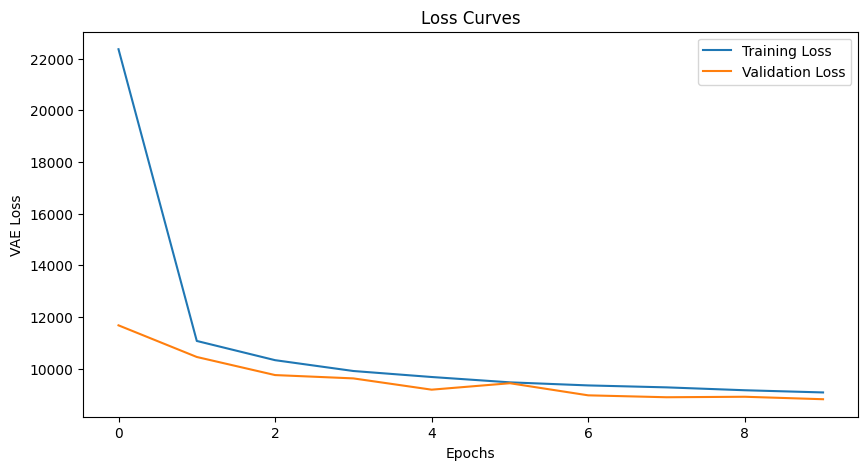

In [6]:
import torch.optim as optim
import matplotlib.pyplot as plt

# Hyperparameters
num_epochs = 10
learning_rate = 1e-3

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model, loss function, and optimizer
model = VariationalAutoencoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Lists to store losses
train_losses = []
val_losses = []

# Initial validation loss check
model.eval()
val_loss = 0
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs, mu, logvar = model(images)
        loss = vae_loss_function(outputs, images, mu, logvar)
        val_loss += loss.item() * images.size(0)
    val_loss /= len(test_loader.dataset)
    print("Initial validation loss:", val_loss)
    show_images(images, outputs)

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for images, _ in train_loader:
        images = images.to(device)

        # Forward pass
        outputs, mu, logvar = model(images)
        loss = vae_loss_function(outputs, images, mu, logvar)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)

    # Average training loss
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(device)
            outputs, mu, logvar = model(images)
            loss = vae_loss_function(outputs, images, mu, logvar)
            val_loss += loss.item() * images.size(0)

        # Average validation loss
        val_loss /= len(test_loader.dataset)
        val_losses.append(val_loss)

        # Save reconstructed images
        show_images(images[:10], outputs[:10])

    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

# Plotting loss curves
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('VAE Loss')
plt.legend()
plt.show()


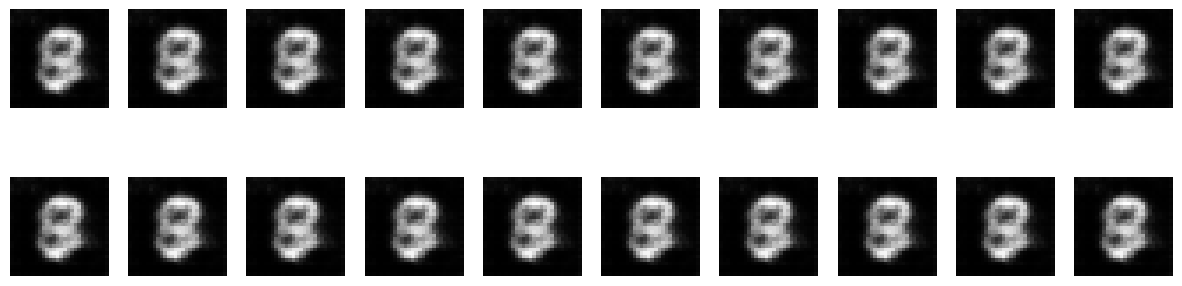

In [7]:
model.eval()
with torch.no_grad():
    images, _ = next(iter(test_loader))
    image = images[0]
    encoded = self.encoder(x)
    mu = model.fc_mu(encoded)       # Mean of the latent space
    logvar = self.fc_logvar(encoded)  # Log-variance of the latent space
    z = self.reparameterize(mu, logvar)  # Sample from the latent space
    decoded = self.decoder(z)      # Decode the sampled latent vector

    random_inputs = torch.zeros(10, bottleneck).to("cuda")
    outputs = model.decoder(random_inputs)
    show_images(outputs[:10], outputs[:10])